<a href="https://colab.research.google.com/github/wafa-b/Introduction-to-Deep-Learning-with-PyTorch/blob/master/Arabic%20Handwriting%20Recognition%20Classification%20Project/Arabic_Handwriting_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Download data from kaggle
import os
os.environ['KAGGLE_USERNAME'] = "wafaab" 
os.environ['KAGGLE_KEY'] = "c3b1752b44ed6f5e678f83cad98a13b2"

In [2]:
!kaggle datasets download -d wafaab/arabic-characters

 50% 9.00M/18.1M [00:00<00:00, 52.8MB/s]
100% 18.1M/18.1M [00:00<00:00, 88.7MB/s]


In [3]:
!unzip arabic-characters

Archive:  arabic-characters.zip
  inflating: Arabic Characters/test/ain/ain1042.jpg  
  inflating: Arabic Characters/test/ain/ain1043.jpg  
  inflating: Arabic Characters/test/ain/ain1098.jpg  
  inflating: Arabic Characters/test/ain/ain1099.jpg  
  inflating: Arabic Characters/test/ain/ain1154.jpg  
  inflating: Arabic Characters/test/ain/ain1155.jpg  
  inflating: Arabic Characters/test/ain/ain1210.jpg  
  inflating: Arabic Characters/test/ain/ain1211.jpg  
  inflating: Arabic Characters/test/ain/ain1266.jpg  
  inflating: Arabic Characters/test/ain/ain1267.jpg  
  inflating: Arabic Characters/test/ain/ain1322.jpg  
  inflating: Arabic Characters/test/ain/ain1323.jpg  
  inflating: Arabic Characters/test/ain/ain1378.jpg  
  inflating: Arabic Characters/test/ain/ain1379.jpg  
  inflating: Arabic Characters/test/ain/ain1434.jpg  
  inflating: Arabic Characters/test/ain/ain1435.jpg  
  inflating: Arabic Characters/test/ain/ain146.jpg  
  inflating: Arabic Characters/test/ain/ain147.jpg 

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
import numpy as np
from torch import nn
from torch import optim
import torch.nn.functional as F
from collections import OrderedDict

from torchvision import datasets, transforms, models
from torch.utils.data.sampler import SubsetRandomSampler

In [5]:
data_dir = 'Arabic Characters'

batch_size = 16
#Define percentage of training set to use as validation
valid_size = 0.2
#Define transforms for the training data and testing data
transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=transforms)

#obtain trainig indicies that will be used as validation
num_train = len(train_data)
indicies = list(range(num_train))
np.random.shuffle(indicies)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indicies[split:], indicies[:split]
#Define samplers for obtaining the training and validation data
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

print('batch_size:', batch_size)
print('length of train dataset:',len(train_data))
print('length of test dataset:',len(test_data))

arabic_characters=['ain', 'alef', 'beh', 'dad', 'dal', 'feh', 'ghain', 'hah', 'heh',
                   'jeem', 'kaf','khah', 'lam', 'meem', 'noon', 'qaf', 'reh', 'sad',
                   'seen', 'sheen', 'tah', 'teh','thal', 'theh', 'waw', 'yeh', 'zah', 'zain']

batch_size: 16
length of train dataset: 13440
length of test dataset: 3360


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

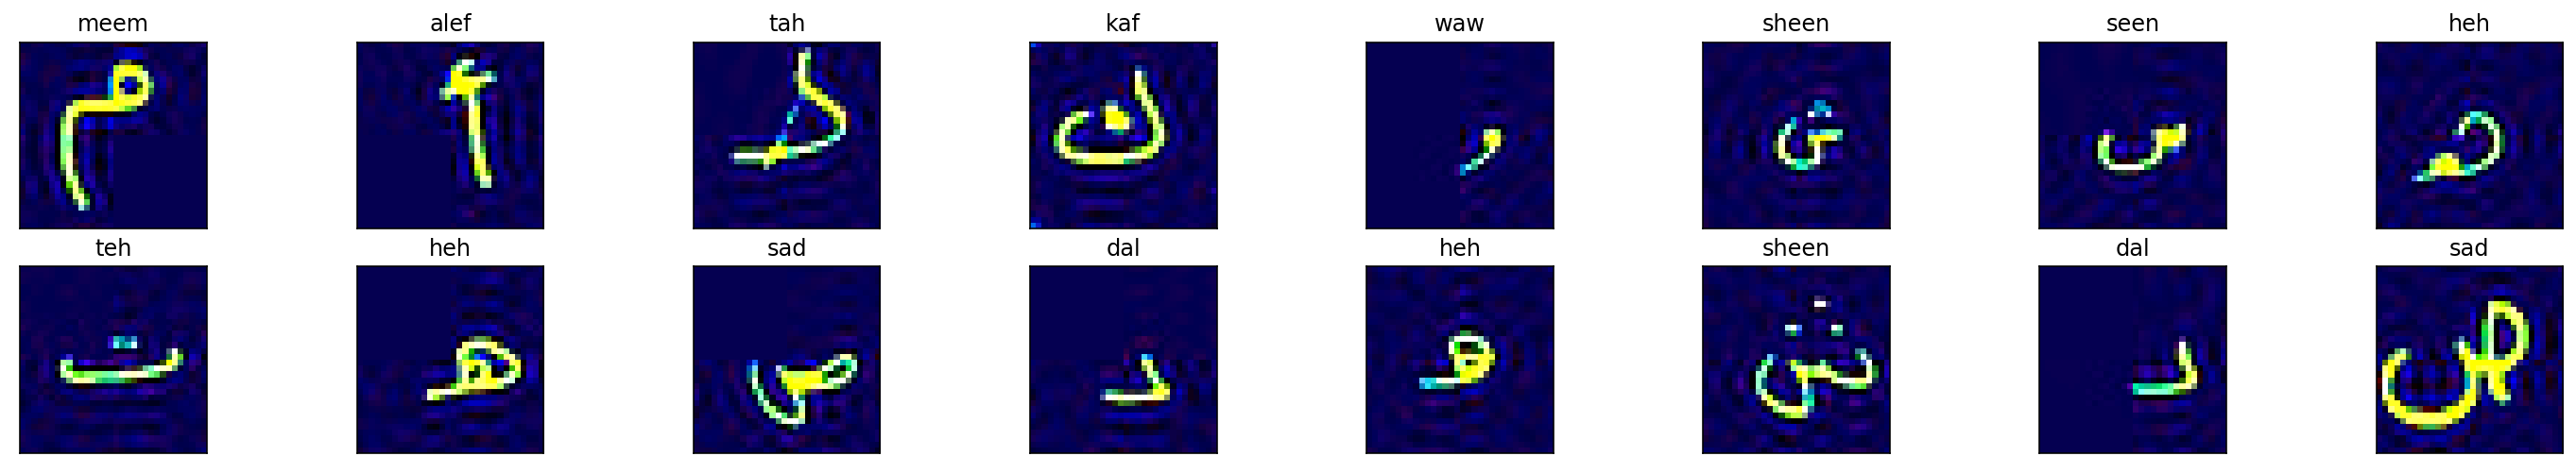

In [6]:
# helper function to un-normalize and display an image
def imshow(img):
    # unnormalize
    img = img / 2 + 0.5  
    # convert from Tensor image
    plt.imshow(np.transpose(img, (1, 2, 0)))  

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
# convert images to numpy for display
images = images.numpy() 

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 16 images
for idx in np.arange(16):
    ax = fig.add_subplot(2, 16/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(arabic_characters[labels[idx]])

In [7]:
model=models.googlenet(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/checkpoints/googlenet-1378be20.pth


GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [11]:
# Use GPU if it's available
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")
model=models.googlenet(pretrained=True)

# Freeze parameters so we don't backprop through them
# for param in model.parameters():
#     param.requires_grad=False 

from collections import OrderedDict
model.classifier=nn.Sequential(OrderedDict([
                                ('fc1',nn.Linear(1024, 256)),
                                ('relu',nn.ReLU()),
                                ('dropout',nn.Dropout(0.25)),
                                ('fc2',nn.Linear(256, 64)),
                                ('reul',nn.ReLU()),
                                ('dropout',nn.Dropout(0.25)),
                                ('fc3',nn.Linear(64, 28)),
                                ('output',nn.LogSoftmax(dim=1))
                                ]))

print(model)

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [0]:
# specify loss function (categorical cross-entropy)
criterion=nn.CrossEntropyLoss()
# Only train the classifier parameters, feature parameters are frozen
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
model.to(device);

In [13]:
# number of epochs to train the model
import numpy as np
n_epochs = 20

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for images, labels in train_loader:
        # move tensors to GPU if CUDA is available
        if device:
            images, labels = images.cuda(), labels.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(images)
        # calculate the batch loss (comapre the values of the output model to the actual labels)
        loss = criterion(output, labels)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*images.size(0)
        
    ######################    
    # validate the model #
    ######################
    model.eval()
    for images, labels in valid_loader:
        # move tensors to GPU if CUDA is available
        if device:
            images, labels = images.cuda(), labels.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(images)
        # calculate the batch loss
        loss = criterion(output, labels)
        # update average validation loss 
        valid_loss += loss.item()*images.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)

        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'arabic_characters.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 2.025045 	Validation Loss: 0.581723
Validation loss decreased (inf --> 0.581723).  Saving model ...
Epoch: 2 	Training Loss: 0.775273 	Validation Loss: 0.330373
Validation loss decreased (0.581723 --> 0.330373).  Saving model ...
Epoch: 3 	Training Loss: 0.513170 	Validation Loss: 0.241470
Validation loss decreased (0.330373 --> 0.241470).  Saving model ...
Epoch: 4 	Training Loss: 0.404945 	Validation Loss: 0.204377
Validation loss decreased (0.241470 --> 0.204377).  Saving model ...
Epoch: 5 	Training Loss: 0.313222 	Validation Loss: 0.198756
Validation loss decreased (0.204377 --> 0.198756).  Saving model ...
Epoch: 6 	Training Loss: 0.256132 	Validation Loss: 0.190798
Validation loss decreased (0.198756 --> 0.190798).  Saving model ...
Epoch: 7 	Training Loss: 0.225993 	Validation Loss: 0.174334
Validation loss decreased (0.190798 --> 0.174334).  Saving model ...
Epoch: 8 	Training Loss: 0.200252 	Validation Loss: 0.151295
Validation loss decreased (0.17433

In [14]:
model.load_state_dict(torch.load('arabic_characters.pt'))

<All keys matched successfully>

In [15]:
#Define lists to monitor test loss and accuracy
test_loss=0.0
class_correct=list(0. for i in range(28))
class_total=list(0. for i in range(28))
#Define model for evaluation
model.eval()
for data,target in test_loader:
    #move tensors to GPU if CUDA is available
    if device:
        data,target=data.cuda(),target.cuda()
    #1.Forward pass:testloadercompute predicted outputs by passing inputs to the model
    output=model(data)
    #2.Calculate the loss
    loss=criterion(output,target)
    #3.Update test loss 
    test_loss+=loss.item()*data.size(0)
    #4.Convert output probabilities to predicted class
    _, pred=torch.max(output,1)
    #5.Compare predictions to true label
    correct=np.squeeze(pred.eq(target.data.view_as(pred)))
    #6.Calculate test accuracy for each object class
    for i in range(len(target)):
        label=target.data[i]
        class_correct[label]+=correct[i].item()
        class_total[label]+=1
# calculate and print avg test loss
test_loss=test_loss/len(test_loader.sampler)
print('Test Loss: {:.6f}\n'.format(test_loss))
for i in range(28):
    if class_total[i]>0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)'%(
            arabic_characters[i],100*class_correct[i]/class_total[i],
            np.sum(class_correct[i]),np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)'%(classes[i]))
        
print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)'%(
    100.*np.sum(class_correct)/np.sum(class_total),
    np.sum(class_correct),np.sum(class_total)))

Test Loss: 0.149341

Test Accuracy of   ain: 94% (113/120)
Test Accuracy of  alef: 99% (119/120)
Test Accuracy of   beh: 99% (119/120)
Test Accuracy of   dad: 94% (113/120)
Test Accuracy of   dal: 95% (114/120)
Test Accuracy of   feh: 95% (115/120)
Test Accuracy of ghain: 94% (113/120)
Test Accuracy of   hah: 100% (120/120)
Test Accuracy of   heh: 96% (116/120)
Test Accuracy of  jeem: 95% (115/120)
Test Accuracy of   kaf: 99% (119/120)
Test Accuracy of  khah: 95% (115/120)
Test Accuracy of   lam: 99% (119/120)
Test Accuracy of  meem: 97% (117/120)
Test Accuracy of  noon: 91% (110/120)
Test Accuracy of   qaf: 92% (111/120)
Test Accuracy of   reh: 99% (119/120)
Test Accuracy of   sad: 96% (116/120)
Test Accuracy of  seen: 100% (120/120)
Test Accuracy of sheen: 98% (118/120)
Test Accuracy of   tah: 95% (115/120)
Test Accuracy of   teh: 95% (115/120)
Test Accuracy of  thal: 94% (113/120)
Test Accuracy of  theh: 90% (109/120)
Test Accuracy of   waw: 95% (114/120)
Test Accuracy of   yeh: 96%

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

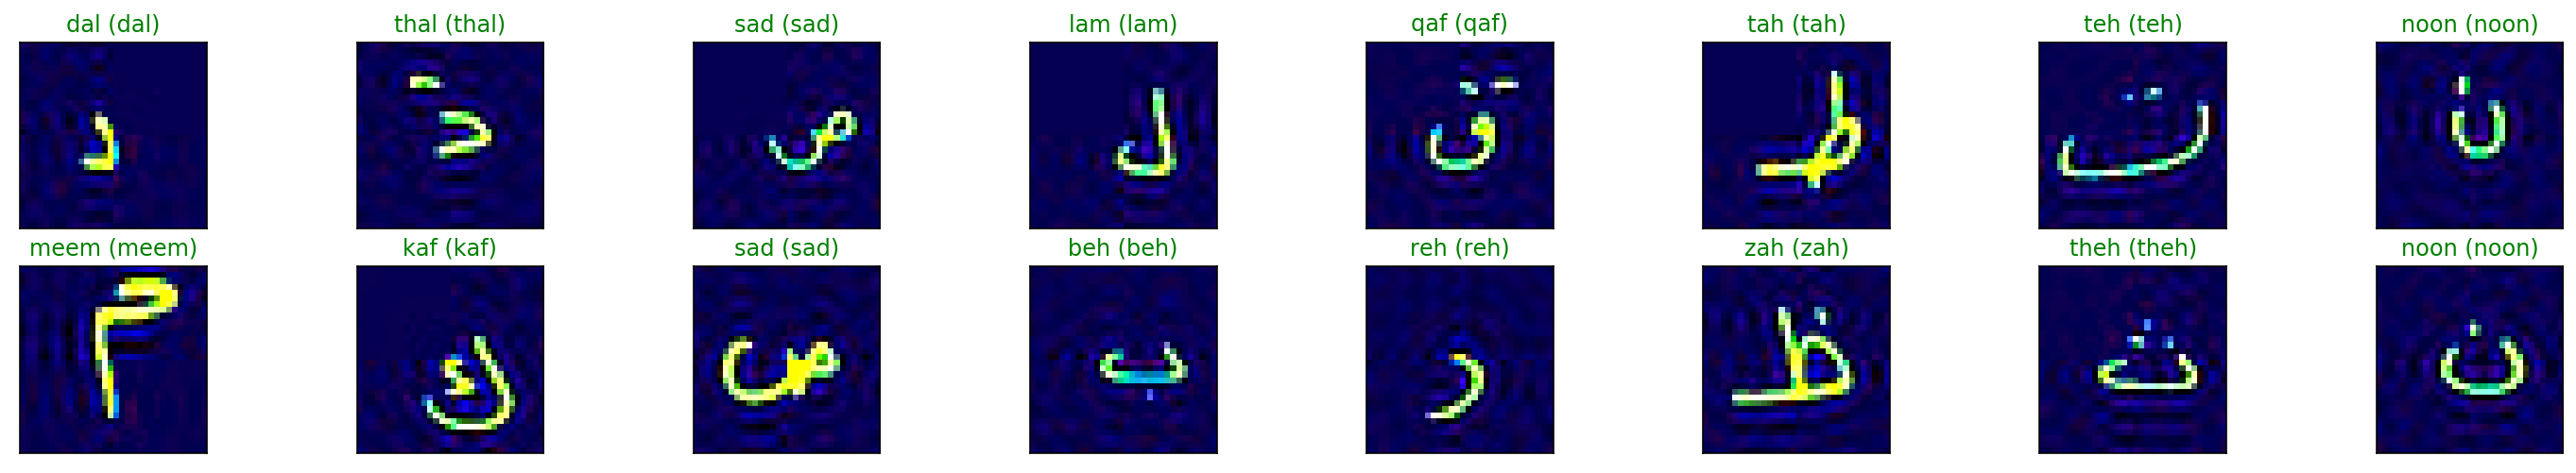

In [16]:
#To see one batch of test images
dataiter=iter(test_loader)
images,labels=dataiter.next()
images.numpy()
#move model inputs to cuda, if GPU available
if device:
    images=images.cuda()
#get sample outputs
output=model(images)
# convert output probabilities to predicted class
_, preds_tensor=torch.max(output,1)
preds=np.squeeze(preds_tensor.numpy()) if not device else np.squeeze(preds_tensor.cpu().numpy())

#plot the images in the batch, along with predicted and true labels
fig=plt.figure(figsize=(25,4))
for idx in np.arange(16):
    ax=fig.add_subplot(2,16/2,idx+1,xticks=[],yticks=[])
    imshow(images.cpu()[idx])
    ax.set_title("{} ({})".format(arabic_characters[preds[idx]],arabic_characters[labels[idx].item()]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))